# 8. Make Predictions

In [1]:
import pandas as pd
import pickle
import json
import os
from collections import defaultdict as dd

In [2]:
with open(f'../models/final_models/model1.pickle', 'rb') as f:
    model1 = pickle.load(f)

In [3]:
with open(f'../models/final_models/model2.pickle', 'rb') as f:
    model2 = pickle.load(f)

In [4]:
with open(f'../models/final_models/model3.pickle', 'rb') as f:
    model3 = pickle.load(f)

In [5]:
with open(f'../models/AFL_pipeline_N.pickle', 'rb') as f:
    sanmin = pickle.load(f)
    
model3_COLS = sanmin.final_features['3']
model2_COLS = sanmin.final_features['2']
model1_COLS = sanmin.final_features['1']

model3_COLS = [x for x in model3_COLS if x not in ['3', '2', '1']]
model2_COLS = [x for x in model2_COLS if x not in ['3', '2', '1']]
model1_COLS = [x for x in model1_COLS if x not in ['3', '2', '1']]

In [6]:
manip_type = 'NormalisedData'

csv_list = os.listdir(f'../data/curated/{manip_type}')
csv_list.sort()

In [40]:
def predict_brownlow(csv_list):
    json_dict = dict()

    tally = dd(int)

    data = pd.DataFrame()
    for file in csv_list:
        if file[-4:] != '.csv':
            continue

        game_dict = dict()
        if '2022' in file:
            
            round = file.split()[2]
            team1 = file.split()[3]
            team2 = file.split()[5]
            game = team1 + ' v ' + team2

            data = pd.read_csv(f'../data/curated/{manip_type}/{file}')

            player = data['Player']
            pred3 = model3.predict(data[model3_COLS])
            pred2 = model2.predict(data[model2_COLS])
            pred1 = model1.predict(data[model1_COLS])
            pred = pd.DataFrame({'player': player, '3': pred3, '2': pred2, '1': pred1})

            three_votes = list(pred.sort_values('3', ascending = False)['player'])[0]

            two_votes = list(pred.sort_values('2', ascending = False)['player'])[0]
            if two_votes == three_votes:
                two_votes = list(pred.sort_values('2', ascending = False)['player'])[1]

            one_vote = list(pred.sort_values('1', ascending = False)['player'])[0]
            if one_vote in (three_votes, two_votes):
                one_vote = list(pred.sort_values('2', ascending = False)['player'])[1]
                
                if one_vote in (three_votes, two_votes):
                    one_vote = list(pred.sort_values('2', ascending = False)['player'])[2]
            
            game_dict[3] = three_votes
            game_dict[2] = two_votes
            game_dict[1] = one_vote

            if f'Round {round}' in json_dict:
                json_dict[f'Round {round}'][game] = game_dict
            else:
                json_dict[f'Round {round}'] = dict()
                json_dict[f'Round {round}'][game] = game_dict

            tally[three_votes] += 3
            tally[two_votes] += 2
            tally[one_vote] += 1
    
    return json_dict, tally

In [41]:
json_dict, tally = predict_brownlow(csv_list) 

In [9]:
with open('../presentables/game_by_game_prediction.json', 'w') as f:
    json.dump(json_dict, f, indent=2)

In [42]:
tally_list = list(tally.items())
tally_list.sort(key = lambda x:x[1], reverse=True)

In [45]:
tally_df = pd.DataFrame(tally_list, columns = ['Player', 'Votes'], index = [i+1 for i in range(len(tally_list))])
tally_df['Ranking'] = tally_df.index
tally_df = tally_df[['Ranking', 'Player', 'Votes']]
tally_df.head(30)

,Ranking,Player,Votes
1,1,Clayton Oliver,35
2,2,Patrick Cripps,28
3,3,Lachie Neale,22
4,4,Jeremy Cameron,21
5,5,Touk Miller,21
6,6,Christian Petracca,20
7,7,Charlie Curnow,20
8,8,Rory Laird,20
9,9,Darcy Parish,19
10,10,Sam Walsh,17


In [46]:
tally_df.to_csv('../presentables/leaderboard.csv', index = False)

# Model Analysis

In [13]:
feature_importance3 = pd.DataFrame({'Features': model3.feature_names_in_, 'Importance': model3.feature_importances_})
feature_importance3 = feature_importance3.sort_values('Importance', ascending=False)
feature_importance3

,Features,Importance
4,Disposals BTN,0.137435
6,Goals BTN,0.126880
5,Disposals OTN,0.081044
16,Effective Disposals BTN,0.057097
22,Score Involvements BTN,0.046285
7,Goals OTN,0.040683
12,Contested Possessions BTN,0.032857
27,Behind Assists BTN,0.031886
8,Inside 50s BTN,0.028910
20,Stoppage Clearances BTN,0.025294


/var/folders/xg/8w_3dndd6l5c3n99vd7vd3f40000gn/T/ipykernel_18602/2906524265.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_importance3['Features'], rotation = 90);


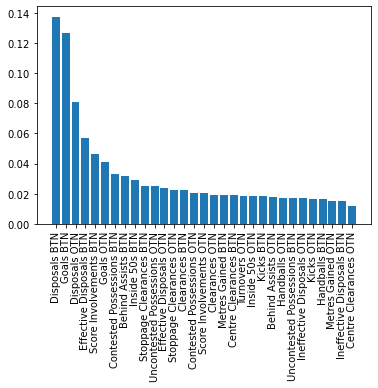

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots();
ax.bar(height= feature_importance3['Importance'],  x = feature_importance3['Features']);
ax.set_xticklabels(feature_importance3['Features'], rotation = 90);

In [15]:
feature_importance2 = pd.DataFrame({'Features': model2.feature_name(), 'Importance': model2.feature_importance()})
feature_importance2['Importance'] = feature_importance2['Importance']/sum(feature_importance2['Importance'])
feature_importance2 = feature_importance2.sort_values('Importance', ascending=False)
feature_importance2

,Features,Importance
6,Goals_BTN,0.096354
4,Disposals_BTN,0.065104
21,Score_Involvements_BTN,0.057292
0,Kicks_BTN,0.046007
11,Contested_Possessions_BTN,0.046007
25,Behind_Assists_BTN,0.039931
18,Centre_Clearances_OTN,0.038194
13,Uncontested_Possessions_BTN,0.038194
12,Contested_Possessions_OTN,0.037326
22,Score_Involvements_OTN,0.037326


/var/folders/xg/8w_3dndd6l5c3n99vd7vd3f40000gn/T/ipykernel_18602/84949849.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_importance2['Features'], rotation = 90);


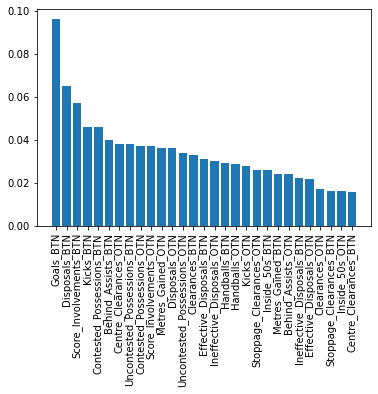

In [16]:
fig, ax = plt.subplots();
ax.bar(height= feature_importance2['Importance'],  x = feature_importance2['Features']);
ax.set_xticklabels(feature_importance2['Features'], rotation = 90);

In [17]:
feature_importance1 = pd.DataFrame({'Features': model1.feature_name(), 'Importance': model1.feature_importance()})
feature_importance1['Importance'] = feature_importance1['Importance']/sum(feature_importance1['Importance'])
feature_importance1 = feature_importance1.sort_values('Importance', ascending=False)
feature_importance1

,Features,Importance
8,Goals_BTN,0.080633
39,Winloss,0.045215
4,Disposals_BTN,0.042954
0,Kicks_BTN,0.042954
33,Score_Involvements_BTN,0.036172
9,Goals_OTN,0.035418
6,Marks_BTN,0.031650
25,Effective_Disposals_BTN,0.030897
21,Contested_Possessions_BTN,0.030143
7,Marks_OTN,0.025622


/var/folders/xg/8w_3dndd6l5c3n99vd7vd3f40000gn/T/ipykernel_18602/3415676281.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_importance1['Features'], rotation = 90);


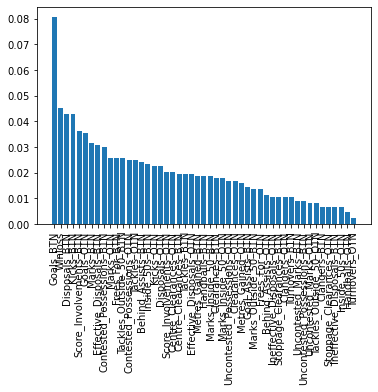

In [18]:
fig, ax = plt.subplots();
ax.bar(height= feature_importance1['Importance'],  x = feature_importance1['Features']);
ax.set_xticklabels(feature_importance1['Features'], rotation = 90);